# Email Newsletter Startup Notebook

This notebook contains a deep dive into multiple solutions for the a newsletter startup.
* Exploratory Data Analysis
* Referral Network Analysis Tool
* Referral Prediction
* Churn Prediction

#### Imports

In [2]:
# Standard Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

# SKLearn Imports
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans

# Network Analysis
from networkx.readwrite import json_graph
import networkx as nx

# Auxiliary Tools
import itertools
import json
import random
from pprint import pprint
from collections import Counter
import datetime
from datetime import datetime as dt
from itertools import product
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
cnx = create_engine('postgresql')

ArgumentError: Could not parse rfc1738 URL from string 'postgresql'

#### Options

In [ ]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

#### SQL Database Overview

In [6]:
pd.read_sql_query('''select * from information_schema.tables ''',cnx).head()

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_name
0,rsdb,information_schema,information_schema_catalog_name,VIEW,None,None,None,None,None
1,rsdb,information_schema,applicable_roles,VIEW,None,None,None,None,None
2,rsdb,information_schema,check_constraints,VIEW,None,None,None,None,None
3,rsdb,information_schema,column_domain_usage,VIEW,None,None,None,None,None
4,rsdb,information_schema,column_privileges,VIEW,None,None,None,None,None


In [8]:
pd.read_sql_query('''select * from information_schema.tables ''',cnx).count()

table_catalog                   367
table_schema                    367
table_name                      367
table_type                      367
self_referencing_column_name      0
reference_generation              0
user_defined_type_catalog         0
user_defined_type_schema          0
user_defined_name                 0
dtype: int64

### Exploratory Data Analysis

In [6]:
df_campaign_tally = pd.read_sql_query('''
                    SELECT CAST(date as DATE) as Date, sum(total_recipients) as total_recipients FROM 
                    (
                    SELECT subject, CAST(sentdate as DATE) as Date, sum(totalrecipients) as total_recipients
                    FROM campaignmonitor_dedicated.campaigns
                    WHERE DATEPART(dw, sentdate) NOT IN (0,6) 
                    AND lower(name) !~* 'ambassador|dedicated share message|re-engage'
                    group by Date, subject
                    
                    UNION 
                    
                    SELECT subject, CAST(sentdate as DATE) as Date, sum(totalrecipients) as total_recipients
                    FROM campaignmonitor.campaigns
                    WHERE DATEPART(dw, sentdate) NOT IN (0,6) 
                    AND lower(name) !~* 'ambassador|dedicated share message|re-engage'
                    group by Date, subject
                    
                    UNION 
                    
                    SELECT DISTINCT title, CAST(send_time as DATE) as Date, recipient_count
                    FROM mailchimp.campaigns 
                    WHERE subject_line NOT LIKE '%%RSSITEM:TITLE%%'
                    AND DATEPART(dw, send_time) NOT IN (0,6) 
                    AND lower(title)  !~* 'garbage|test|insider|copy|happyhour|join FB page|community|light roast|lr'
                    AND status = 'sent'
                    group by Date, title, recipient_count
                    
                    UNION
                    
                    SELECT DISTINCT title, CAST(send_time as DATE) as Date, recipient_count
                    FROM mailchimp_stage.campaigns 
                    WHERE  subject_line NOT LIKE '%%RSSITEM:TITLE%%'
                    AND DATEPART(dw, send_time) NOT IN (0,6) 
                    AND lower(title)  !~* 'garbage|test|insider|copy|happyhour|join FB page|community|light roast|lr'
                    AND status = 'sent'
                    group by Date, title, recipient_count
                    ) as recipients_by_day
                    GROUP BY CAST(date as DATE)
                    ORDER BY CAST(date as DATE) DESC
                   ''', cnx)
df_campaign_tally = df_campaign_tally.iloc[1:]

In [7]:
df_campaign_LR_tally = pd.read_sql_query('''
                    SELECT CAST(date as DATE) as Date, sum(total_recipients) as total_recipients FROM 
                    (
                    SELECT subject, CAST(sentdate as DATE) as Date, sum(totalrecipients) as total_recipients
                    FROM campaignmonitor_dedicated.campaigns
                    WHERE DATEPART(dw, sentdate) IN (0,6) AND name NOT LIKE '%%insider%%' AND subject NOT LIKE '%%Insider%%'
                    group by Date, subject
                    
                    UNION 
                    
                    SELECT subject, CAST(sentdate as DATE) as Date, sum(totalrecipients) as total_recipients
                    FROM campaignmonitor.campaigns
                    WHERE DATEPART(dw, sentdate) IN (0,6) AND name NOT LIKE '%%insider%%' AND subject NOT LIKE '%%Insider%%'
                    group by Date, subject
                    
                    UNION 
                    
                    SELECT DISTINCT title, CAST(send_time as DATE) as Date, recipient_count
                    FROM mailchimp.campaigns 
                    WHERE subject_line NOT LIKE '%%RSSITEM:TITLE%%'
                    AND DATEPART(dw, send_time) IN (0,6) 
                    AND status = 'sent'
                    group by Date, title, recipient_count
                    
                    UNION
                    
                    SELECT DISTINCT title, CAST(send_time as DATE) as Date, recipient_count
                    FROM mailchimp_stage.campaigns 
                    WHERE subject_line NOT LIKE '%%RSSITEM:TITLE%%'
                    AND DATEPART(dw, send_time) IN (0,6) 
                    AND status = 'sent'
                    group by Date, title, recipient_count
                    ) as recipients_by_day
                    GROUP BY CAST(date as DATE)
                    ORDER BY CAST(date as DATE) DESC
                   ''', cnx)

In [8]:
df_campaign_Insider_tally = pd.read_sql_query('''
                    SELECT CAST(date as DATE) as Date, sum(total_recipients) as total_recipients FROM 
                    (
                    SELECT subject, CAST(sentdate as DATE) as Date, sum(totalrecipients) as total_recipients
                    FROM campaignmonitor_dedicated.campaigns
                    WHERE (name ~* 'insider| >=? 10' OR subject LIKE '%%Insider%%') and name NOT LIKE '%%< 10%%'
                    group by Date, subject
                    
                    UNION 
                    
                    SELECT subject, CAST(sentdate as DATE) as Date, sum(totalrecipients) as total_recipients
                    FROM campaignmonitor.campaigns
                    WHERE (name ~* 'insider| >=? 10' OR subject LIKE '%%Insider%%') and name NOT LIKE '%%< 10%%'
                    group by Date, subject
                    
                    UNION 
                    
                    SELECT DISTINCT title, CAST(send_time as DATE) as Date, recipient_count
                    FROM mailchimp.campaigns 
                    WHERE subject_line NOT LIKE '%%RSSITEM:TITLE%%'
                    AND list_name = 'Full Brunch'                    
                    AND status = 'sent'
                    group by Date, title, recipient_count
                    
                    UNION
                    
                    SELECT DISTINCT title, CAST(send_time as DATE) as Date, recipient_count
                    FROM mailchimp_stage.campaigns 
                    WHERE subject_line NOT LIKE '%%RSSITEM:TITLE%%'
                    AND list_name = 'Full Brunch'
                    AND status = 'sent'
                    group by Date, title, recipient_count
                    ) as recipients_by_day
                    GROUP BY CAST(date as DATE)
                    ORDER BY CAST(date as DATE) DESC
                   ''', cnx)

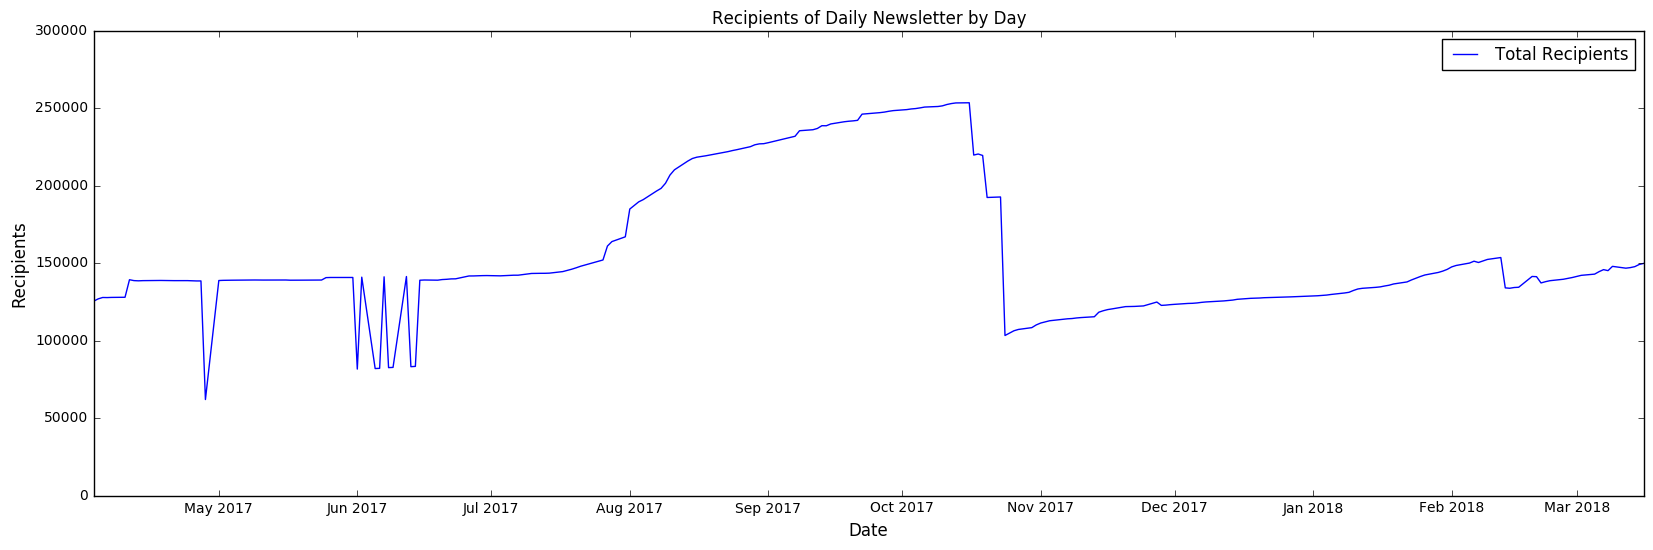

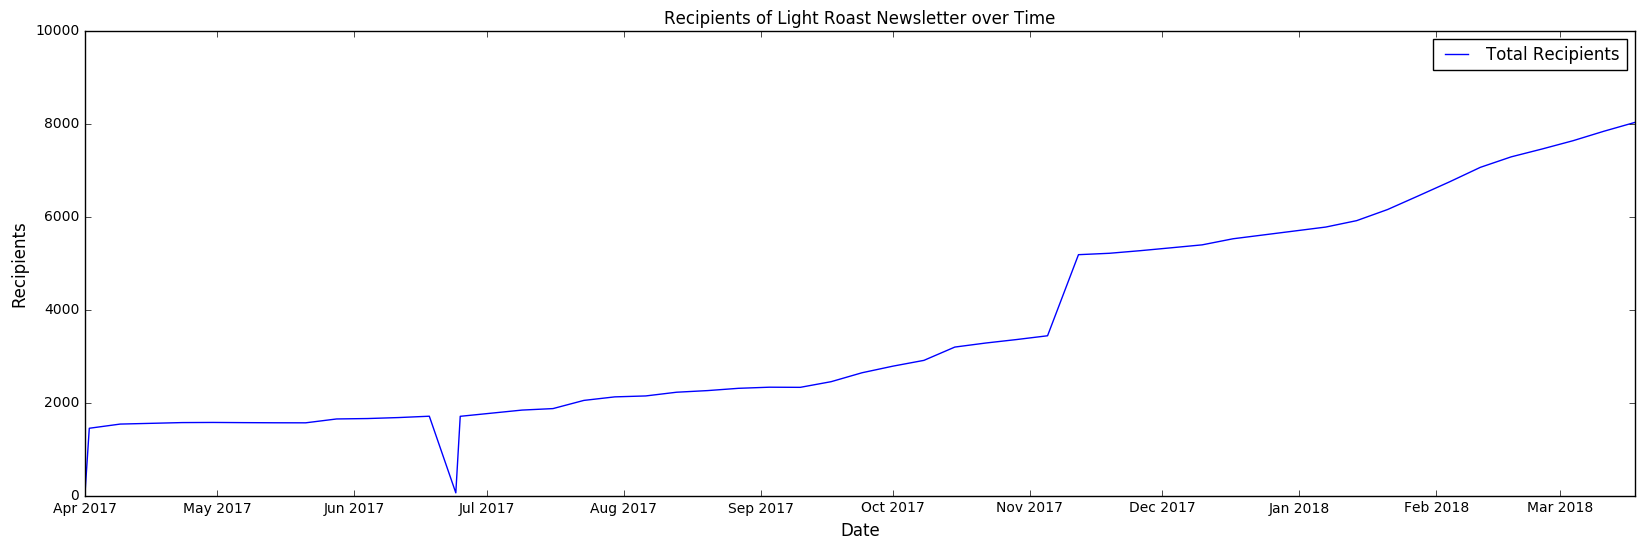

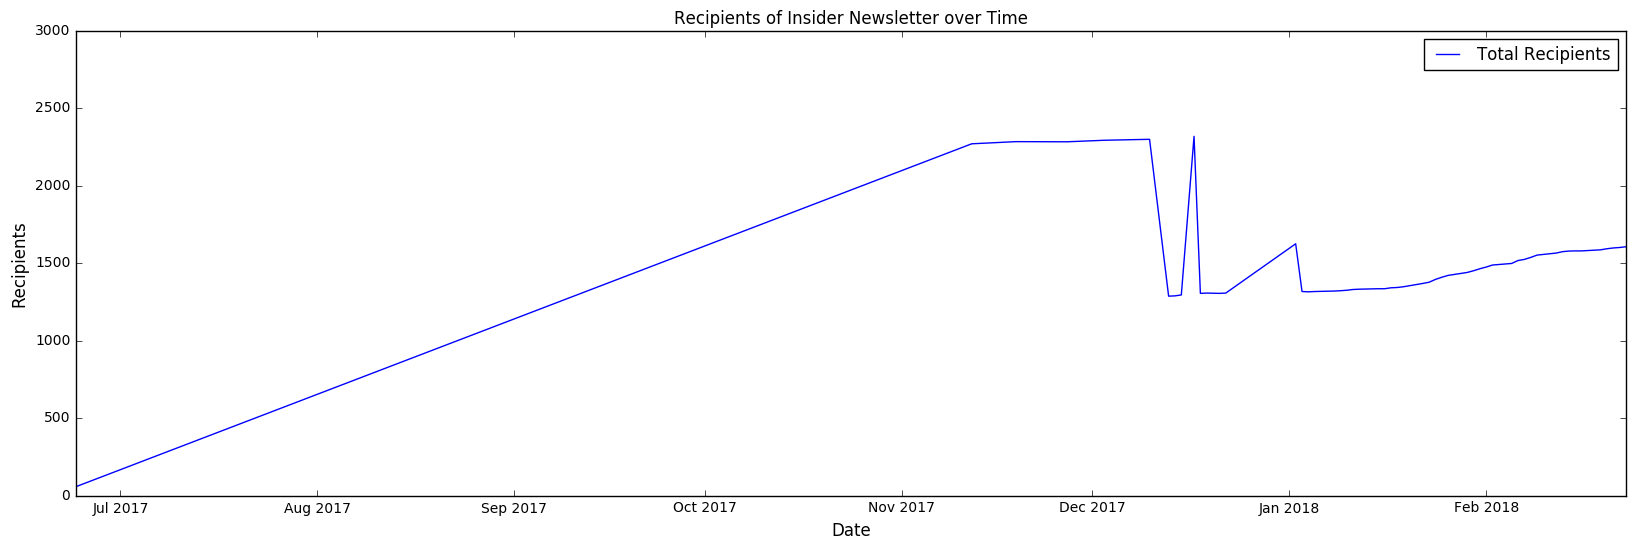

In [9]:
df_campaign_tally.plot.line(x='date', y='total_recipients', figsize = (20,6), ylim =(0,300000))
plt.xlabel('Date', fontsize =12)
plt.ylabel('Recipients', fontsize =12)
plt.legend(['Total Recipients'])
plt.title('Recipients of Daily Newsletter by Day')
df_campaign_LR_tally.plot.line(x='date', y='total_recipients', figsize = (20,6), ylim =(0,10000))
plt.xlabel('Date', fontsize =12)
plt.ylabel('Recipients', fontsize =12)
plt.legend(['Total Recipients'])
plt.title('Recipients of Light Roast Newsletter over Time')
df_campaign_Insider_tally.plot.line(x='date', y='total_recipients', figsize = (20,6), ylim =(0,3000))
plt.xlabel('Date', fontsize =12)
plt.ylabel('Recipients', fontsize =12)
plt.legend(['Total Recipients'])
plt.title('Recipients of Insider Newsletter over Time');

### Data Cleaning

In [10]:
# Creating linked table of referrers and referred
df_referrer_linkage = pd.read_sql_query('''With subquery AS
                    (SELECT id, email, referral_code, referrer_id, referral_count, region, countryname, region_count, CAST(created_at as DATE), sid 
                    
                        FROM pg.users
                    
                    JOIN 
                        
                        (SELECT emailaddress, region, countryname, region_count
                            FROM
                                (
                                SELECT DISTINCT emailaddress, region, countryname, region_count, 
                                    ROW_NUMBER() OVER (PARTITION BY emailaddress 
                                       ORDER BY region_count DESC) AS rn
                                
                                    FROM (
                                        SELECT DISTINCT emailaddress, region, countryname, count(region) as region_count 
                                        FROM campaignmonitor_dedicated.opens
                                        GROUP by emailaddress, region, countryname
                                    ) t
                                    
                                ) s
                        WHERE s.rn = 1
                        group by s.emailaddress, s.region, countryname, region_count
                        order by s.emailaddress) 
                        as user_statecountry on users.email = user_statecountry.emailaddress
                    )
                    SELECT DISTINCT q1.id, q1.email, q1.referral_code, q1.referral_count, q1.region, q1.countryname, q1.region_count, CAST(q1.created_at as DATE) as created_date,
                        q2.id as referrer_id, q2.email as referrer_email, q2.referral_count as referrer_referral_count, q2.region as referrer_region, 
                        q2.countryname as referrer_country, q2.region_count as referrer_regioncount, CAST(q2.created_at as DATE) as referrer_created_date, q1.sid

                    FROM subquery q1 
                    
                    FULL JOIN
                    
                    subquery q2 on q1.referrer_id = q2.id

''', cnx)

In [11]:
# Table of Unsubscribes
df_unsubscribes = pd.read_sql_query('''SELECT emailaddress, date 
                    FROM campaignmonitor_dedicated.unsubscribes 
                    
                    UNION 
                    
                    SELECT emailaddress, date 
                    FROM campaignmonitor.unsubscribes  
''', cnx)

##### Initial Active Readership

In [12]:
# MailChimp - Initial Active User Readership
df_initial_active_user_mc = pd.read_sql_query('''
With subquery2 as (
        SELECT id, email, CAST(created_at as DATE) as Created_at

        FROM pg.users
        ),
        
subquery3 as (
        SELECT CAST(timestamp as DATE) as Open_Date, CAST(create_time as DATE) as Email_Sent_Date, email_address

        FROM mailchimp.email_activity

        JOIN 

        mailchimp.campaigns on mailchimp.campaigns.id =  mailchimp.email_activity.campaign_id

        WHERE mailchimp.email_activity.action = 'open'
        )

SELECT email_address as emailaddress, count(DISTINCT read_since_create) as newsletters_opened_in_first_10 FROM   
    (SELECT subquery3.Open_Date - subquery2.Created_at as read_since_create, subquery3.email_address
        from subquery3 
        JOIN 
        subquery2 on
        subquery2.email = subquery3.email_address) B
        
where B.read_since_create < 11
group by B.email_address

''',cnx)

In [13]:
# CampaignMonitor - Initial Active User Readership
df_initial_active_user_cm = pd.read_sql_query(''' 
With subquery1 as(
        SELECT emailaddress, CAST(date as DATE) as Newsletter_date, Count(DISTINCT campaignid) as campaign_read_count 
            FROM campaignmonitor.opens
            group by emailaddress, Newsletter_date

        UNION

        SELECT emailaddress, CAST(date as DATE) as Newsletter_date, Count(DISTINCT campaignid) as campaign_read_count 
                FROM campaignmonitor_dedicated.opens
                group by emailaddress, Newsletter_date
),

subquery2 as (
        SELECT id, email, CAST(created_at as DATE) as Created_at, rep

        FROM pg.users

)


select emailaddress, count(DISTINCT read_since_create) as newsletters_opened_in_first_10 from 
        (SELECT subquery1.emailaddress, subquery1.Newsletter_date, subquery2.id, subquery2.Created_at,
                subquery1.Newsletter_date - subquery2.Created_at as read_since_create, subquery1.campaign_read_count

        FROM subquery1

        FULL JOIN 

        subquery2 on subquery1.emailaddress = subquery2.email) A


where A.read_since_create < 11
group by emailaddress
''',cnx)

In [14]:
# Combined DataFrame
df_initial_user_combined = pd.concat([df_initial_active_user_cm, df_initial_active_user_mc]).groupby('emailaddress').sum().reset_index()

### Feature Engineering

In [15]:
df_unsubscribes.columns = ['emailaddress', 'unsubscribe_date']

In [16]:
df_refer_unsubscribe = pd.merge(df_referrer_linkage, df_unsubscribes,\
                                how = 'outer', left_on = df_referrer_linkage.email,\
                                right_on = df_unsubscribes.emailaddress)

In [17]:
df_refer_unsubscribe['created_date'] = pd.to_datetime(df_refer_unsubscribe['created_date'])
df_refer_unsubscribe['referrer_created_date'] = pd.to_datetime(df_refer_unsubscribe['referrer_created_date'])
df_refer_unsubscribe['unsubscribe_date'] = pd.to_datetime(df_refer_unsubscribe['unsubscribe_date'])
df_refer_unsubscribe['Time_to_Unsubscribe'] = df_refer_unsubscribe['unsubscribe_date'] - df_refer_unsubscribe['created_date']

In [18]:
# Get rid of nulls on recipient side and remove any duplicated emails
df_refer_unsubscribe = df_refer_unsubscribe[df_refer_unsubscribe.email.notnull()].drop_duplicates(subset = 'email')

In [19]:
# Create metric that measures difference in time from referrer signup to referral signup
df_refer_unsubscribe['Time_to_refer'] = df_refer_unsubscribe['created_date'] - df_refer_unsubscribe['referrer_created_date']

In [20]:
df_refer_unsubscribe['Time_to_refer_int'] = df_refer_unsubscribe['Time_to_refer'].dt.days

In [21]:
df_refer_unsubscribe['Time_to_Unsubscribe_int'] = df_refer_unsubscribe['Time_to_Unsubscribe'].dt.days

In [22]:
# Pickle Save
df_refer_unsubscribe.to_pickle('df_refer_unsubscribe_concat.pickle')
df_refer_unsubscribe = pd.read_pickle('df_refer_unsubscribe_concat.pickle')

In [25]:
df_refer_unsubscribe_active = pd.merge(df_refer_unsubscribe, \
                                       df_initial_user_combined, how = 'outer',\
                                       left_on =df_refer_unsubscribe['email'], right_on = df_initial_user_combined['emailaddress'])

df_refer_unsubscribe_active.drop(['emailaddress_y'], axis=1, inplace=True)

df_refer_unsubscribe_active['newsletter_read_bool'] = df_refer_unsubscribe_active['newsletters_opened_in_first_10']\
                                                .apply(lambda x: 1 if pd.notnull(x) else 0)
df_refer_unsubscribe_active['newsletter_read_over_5_bool'] = df_refer_unsubscribe_active['newsletters_opened_in_first_10']\
                                                .apply(lambda x: 1 if x > 4 else 0)

In [26]:
# Defining Referrer Level
def referrer_level(x):
    if x == 0:
        return 1
    elif (x>0 and x<3):
        return 2
    elif (x>2 and x<5):
        return 3
    elif (x>4 and x<10):
        return 4
    else: 
        return 5

In [36]:
# Apply Referrel Level Function
df_refer_unsubscribe_active['Referrer_Level'] = df_refer_unsubscribe_active['referral_count'].apply(referrer_level)

# Create Boolean for signup from Referral
df_refer_unsubscribe_active['Was_referred_bool'] = df_refer_unsubscribe_active['emailaddress_x'].apply(lambda x: 1 if pd.notnull(x) else 0)

# Cleaning Newsletters Opened in First 10 Days
df_refer_unsubscribe_active['newsletters_opened_in_first_10'] = df_refer_unsubscribe_active['newsletters_opened_in_first_10'].apply(lambda x: 0 if pd.isnull(x) else x)

# Create Boolean for Referrer Level
df_refer_unsubscribe_active['Referred_at_least_one'] = df_refer_unsubscribe_active['Referrer_Level']\
                                                            .apply(lambda x: 1 if x >1 else 0)
# Create Boolean for College Email
df_refer_unsubscribe_active['College_email_bool'] = df_refer_unsubscribe_active['email']\
                                                        .apply(lambda x: 1 if str(x)[-3:] == 'edu' else 0)

# Create Boolean for Unsubscribe
df_refer_unsubscribe_active['Unsubscribed_Bool'] = df_refer_unsubscribe_active['unsubscribe_date']\
                                                .apply(lambda x: 1 if pd.notnull(x) else 0)

# Create Boolean for Referred Someone
df_refer_unsubscribe_active['referred_someone_Bool'] = df_refer_unsubscribe_active['referral_count']\
                                                .apply(lambda x: 0 if x == 0 else 1)
    
# Create Simplified Referrer Level Groupings
df_refer_unsubscribe_active['Referrer_Level_Simplified'] = df_refer_unsubscribe_active['referral_count']\
                                                            .apply(lambda x: 2 if x >9 else (0 if x==0 else 1))

##### Import Acquisition Source Data

In [35]:
df_source = pd.read_csv('Source_ID_Brew.csv')

In [37]:
df_source.head()

,Code,Paid/Unpaid,Source
0,0000000,ERROR,Some Error occured and defaulted to 0000000
1,0001001,unpaid,LP for General
2,0002001,unpaid,LP for Referred
3,0003001,unpaid,/latest
4,0004001,unpaid,/latest


In [38]:
df_refer_unsubscribe_active_p2 = pd.merge(df_refer_unsubscribe_active,df_source, how='outer',\
             left_on = df_refer_unsubscribe_active['sid'], right_on = df_source['Code'])

In [39]:
df_refer_unsubscribe_active_p2.head()

,id,email,referral_code,referral_count,region,countryname,region_count,created_date,referrer_id,referrer_email,referrer_referral_count,referrer_region,referrer_country,referrer_regioncount,referrer_created_date,sid,emailaddress_x,unsubscribe_date,Time_to_Unsubscribe,Time_to_refer,Time_to_refer_int,Time_to_Unsubscribe_int,newsletters_opened_in_first_10,newsletter_read_bool,newsletter_read_over_5_bool,Referrer_Level,Was_referred_bool,Referred_at_least_one,College_email_bool,Unsubscribed_Bool,referred_someone_Bool,Referrer_Level_Simplified,Code,Paid/Unpaid,Source
0,385424.0,pierini.michele@gmail.com,e1e31f,0.0,Texas,United States of America,17.0,2018-01-28,195829.0,thesmartestmuffin@gmail.com,4.0,New York,United States of America,20.0,2017-07-14,0002001,NaN,NaT,NaT,198 days,198.0,NaN,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred
1,342582.0,adam.milito@queensu.ca,1a31f0,0.0,Ontario,Canada,126.0,2017-10-12,177607.0,andrei_florescu@ymail.com,2.0,Ontario,Canada,122.0,2017-04-17,0002001,NaN,NaT,NaT,178 days,178.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred
2,350237.0,ruiwen@gmail.com,8113dc,0.0,New York,United States of America,3.0,2017-11-02,36924.0,landon.medlock@gmail.com,8.0,New York,United States of America,4.0,2016-09-28,0002001,ruiwen@gmail.com,2018-01-03 03:16:00,62 days 03:16:00,400 days,400.0,62.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0002001,unpaid,LP for Referred
3,373343.0,20mearrac@blraiders.org,b80b20,0.0,Texas,United States of America,4.0,2018-01-11,32590.0,wooda@benjaminlogan.org,108.0,New York,United States of America,13.0,2016-09-28,0002001,NaN,NaT,NaT,470 days,470.0,NaN,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred
4,340948.0,gurmansihota@gmail.com,d186d6,0.0,California,United States of America,72.0,2017-10-10,100932.0,michong@umich.edu,302.0,New York,United States of America,31.0,2017-01-26,0002001,NaN,NaT,NaT,257 days,257.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred


In [40]:
df_refer_unsubscribe_active_p2['Paid/Unpaid'] = df_refer_unsubscribe_active_p2['Paid/Unpaid'].astype('category')

In [41]:
df_refer_unsubscribe_active_p2 = pd.concat([df_refer_unsubscribe_active_p2\
                                        ,pd.get_dummies(df_refer_unsubscribe_active_p2['Paid/Unpaid'],  drop_first=True)]\
                                        ,axis =1)

In [42]:
df_refer_unsubscribe_active_p2.dropna(axis=0, subset =['Referrer_Level'], inplace=True)

In [44]:
df_refer_unsubscribe_active_p2.rename(columns ={'rep_x':'is_rep','rep_y':'referred_by_rep'}, inplace=True)

In [45]:
df_refer_unsubscribe_active_p2.head()

,id,email,referral_code,referral_count,region,countryname,region_count,created_date,referrer_id,referrer_email,referrer_referral_count,referrer_region,referrer_country,referrer_regioncount,referrer_created_date,sid,emailaddress_x,unsubscribe_date,Time_to_Unsubscribe,Time_to_refer,Time_to_refer_int,Time_to_Unsubscribe_int,newsletters_opened_in_first_10,newsletter_read_bool,newsletter_read_over_5_bool,Referrer_Level,Was_referred_bool,Referred_at_least_one,College_email_bool,Unsubscribed_Bool,referred_someone_Bool,Referrer_Level_Simplified,Code,Paid/Unpaid,Source,paid,unpaid
0,385424.0,pierini.michele@gmail.com,e1e31f,0.0,Texas,United States of America,17.0,2018-01-28,195829.0,thesmartestmuffin@gmail.com,4.0,New York,United States of America,20.0,2017-07-14,0002001,NaN,NaT,NaT,198 days,198.0,NaN,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
1,342582.0,adam.milito@queensu.ca,1a31f0,0.0,Ontario,Canada,126.0,2017-10-12,177607.0,andrei_florescu@ymail.com,2.0,Ontario,Canada,122.0,2017-04-17,0002001,NaN,NaT,NaT,178 days,178.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
2,350237.0,ruiwen@gmail.com,8113dc,0.0,New York,United States of America,3.0,2017-11-02,36924.0,landon.medlock@gmail.com,8.0,New York,United States of America,4.0,2016-09-28,0002001,ruiwen@gmail.com,2018-01-03 03:16:00,62 days 03:16:00,400 days,400.0,62.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
3,373343.0,20mearrac@blraiders.org,b80b20,0.0,Texas,United States of America,4.0,2018-01-11,32590.0,wooda@benjaminlogan.org,108.0,New York,United States of America,13.0,2016-09-28,0002001,NaN,NaT,NaT,470 days,470.0,NaN,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
4,340948.0,gurmansihota@gmail.com,d186d6,0.0,California,United States of America,72.0,2017-10-10,100932.0,michong@umich.edu,302.0,New York,United States of America,31.0,2017-01-26,0002001,NaN,NaT,NaT,257 days,257.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1


In [9]:
# Pickle Save
df_refer_unsubscribe_active_p2 = pd.read_pickle('/Users/williamstokvis/Education/metis/Projects/projectKojak/ForUploading/pickles/df_refer_unsubscribe_activep5.pickle')

## Modeling

### Referrer Prediction

In [4]:
count_of_no_referral = df_refer_unsubscribe_active_p2.Referred_at_least_one.value_counts()[0]

In [11]:
# Separate majority and minority classes
df_majority_refer = df_refer_unsubscribe_active_p2[df_refer_unsubscribe_active_p2.Referred_at_least_one==0]
df_minority_refer = df_refer_unsubscribe_active_p2[df_refer_unsubscribe_active_p2.Referred_at_least_one==1]
 
# Upsample minority class
df_minority_upsampled_refer = resample(df_minority_refer, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(count_of_no_referral/2),    # to match majority class
                                 random_state=444)

In [52]:
df_upsampled_refer = pd.concat([df_majority_refer, df_minority_upsampled_refer])

In [75]:
variables = ['newsletter_read_bool', 'newsletters_opened_in_first_10',\
             'Was_referred_bool','College_email_bool','unpaid','paid']
X1 = df_refer_unsubscribe_active_p2[variables]
y1 = df_refer_unsubscribe_active_p2['Referred_at_least_one']

In [87]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1, test_size = .3 , random_state =444, shuffle =True)

In [88]:
rf = RandomForestClassifier(random_state=444)

In [89]:
model_refer = rf.fit(X_train1, y_train1)

In [90]:
y_pred1 = model_refer.predict(X_test1)

In [91]:
model_refer.feature_importances_

array([0.17, 0.35, 0.02, 0.01, 0.28, 0.18])

In [92]:
confusion_matrix(y_test1, y_pred1)

array([[46041,   170],
       [ 5031,  1335]])

In [93]:
class_names1 = ['No Referral','Referral']

Confusion matrix, without normalization
[[46041   170]
 [ 5031  1335]]
Normalized confusion matrix
[[1.   0.  ]
 [0.79 0.21]]


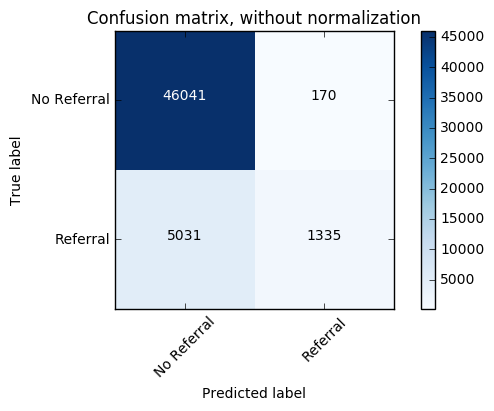

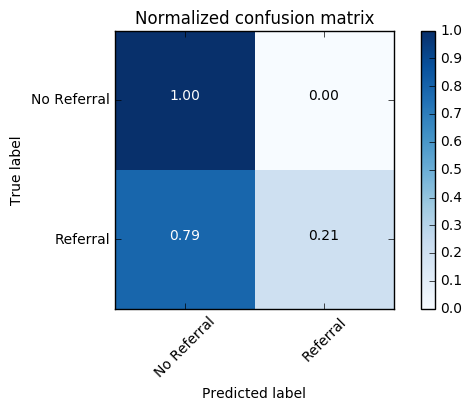

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if normalize:
        plt.clim(0,1)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test1, y_pred1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Referrer Exploration

In [97]:
referrer_index_count = list(df_refer_unsubscribe[(df_refer_unsubscribe.Time_to_refer_int >= 0) &\
                                                 (df_refer_unsubscribe.referrer_email.str.contains('@company')==False) &\
                                                 (df_refer_unsubscribe.referrer_email != 'davepell@gmail.com')&\
                                                    (df_refer_unsubscribe.referrer_email != 'ajla@theneed2know.com')]\
                                                    .groupby('Time_to_refer_int')['id'].count().index)

In [98]:
refer_counts = list(df_refer_unsubscribe[(df_refer_unsubscribe.Time_to_refer_int >= 0) &\
                                                 (df_refer_unsubscribe.referrer_email.str.contains('@company')==False) &\
                                                    (df_refer_unsubscribe.referrer_email != 'davepell@gmail.com')&\
                                                    (df_refer_unsubscribe.referrer_email != 'ajla@theneed2know.com')]\
                                                    .groupby('Time_to_refer_int')['id'].count())

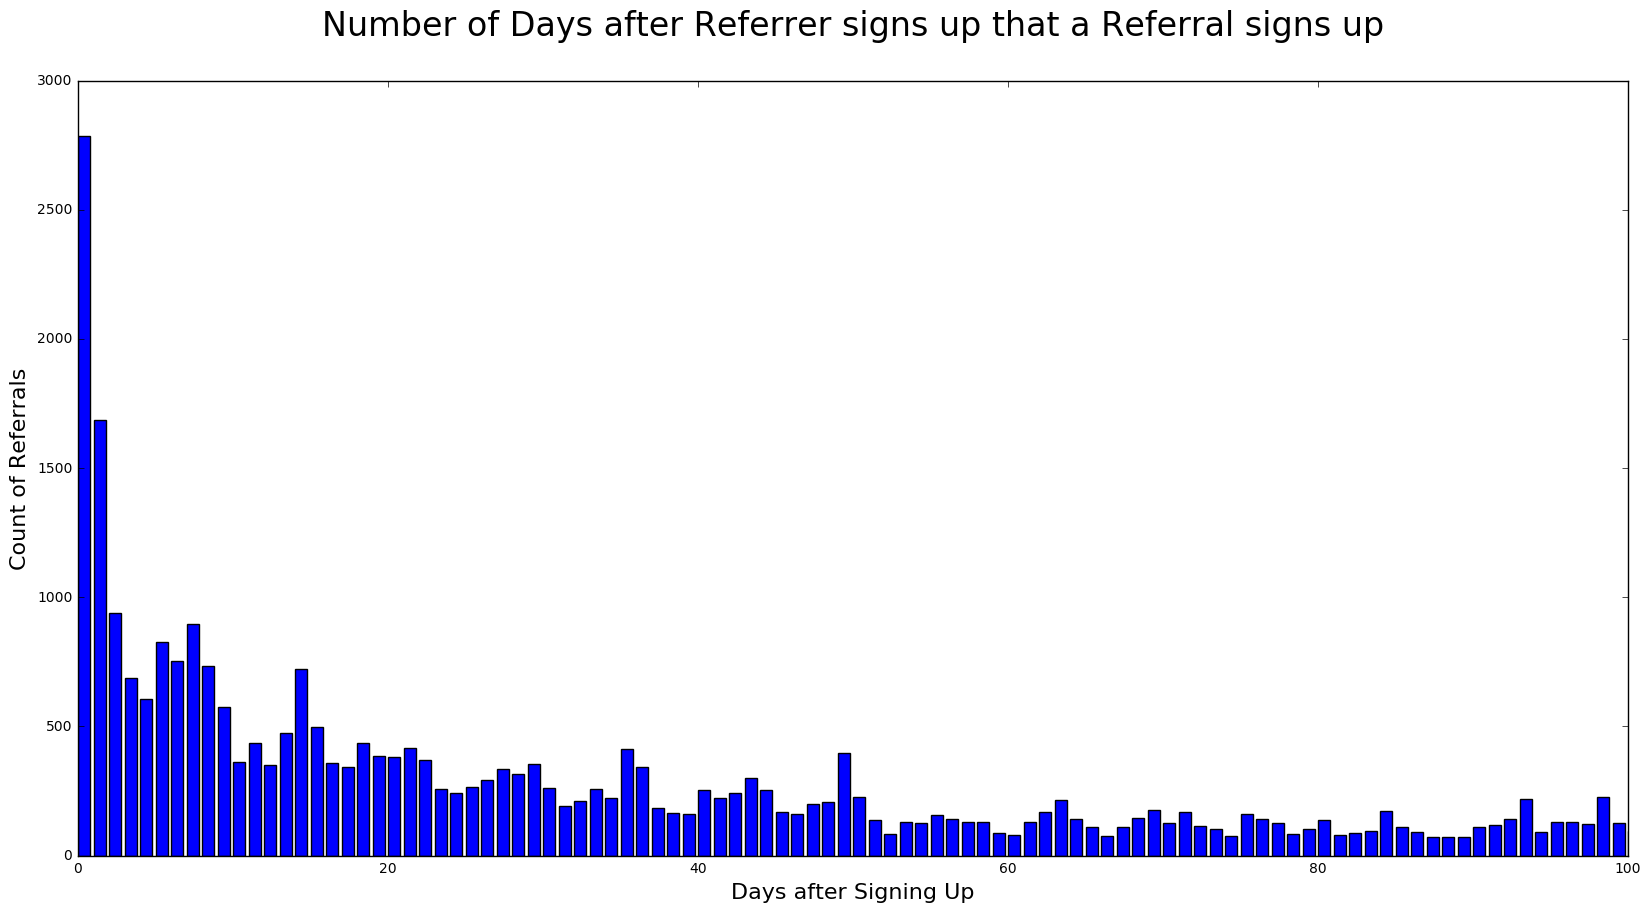

In [100]:
plt.figure(figsize = (20,10))
plt.bar(referrer_index_count,
        refer_counts)
plt.xlim((0,100))
plt.xlabel('Days after Signing Up', fontsize = 16)
plt.ylabel('Count of Referrals', fontsize = 16)
plt.title('Number of Days after Referrer signs up that a Referral signs up\n', fontsize = 24);

## Readership and Unsubscribe Analysis

In [10]:
df = pd.read_sql_query('''
                    
WITH subquery1 as (

SELECT campaignid, max(recipients) as recipients, max(uniqueopened) as opened, max(clicks) as clicks, max(unsubscribed) as unsubscribed
FROM campaignmonitor_aggregate.summary 
group by campaignid

),

subquery2 as (

SELECT subject, CAST(sentdate as DATE) as date, campaignid
FROM campaignmonitor_aggregate.campaigns
WHERE DATEPART(dw, sentdate) NOT IN (0,6) 
AND lower(name) !~* 'ambassador|dedicated share message|re-engage'
group by date, subject, campaignid
) 

SELECT subject, CAST(date as DATE) as date, sum(recipients) as recipients, sum(opened) as opened, sum(clicks) as clicks, sum(unsubscribed) as unsubscribes
FROM subquery2
JOIN

subquery1 on subquery1.campaignid = subquery2.campaignid
group by subject, date
order by date DESC               
                
                   ''', cnx)


In [11]:
# Open Rate
df['open_rate'] = df['opened']/df['recipients']
# Click Rate
df['click_rate'] = df['clicks']/df['recipients']
# Click Engagement Rate
df['click_engagement_rate'] = df['clicks']/df['opened']

In [12]:
# Eliminating First Days of Transition from MailChimp to CampaignMonitor
df = df.iloc[:-6]

In [13]:
df.iloc[:,1:].head(25)

,date,recipients,opened,clicks,unsubscribes,open_rate,click_rate,click_engagement_rate
0,2018-03-29,163694.0,80625.0,3620.0,229.0,0.492535,0.022114,0.044899
1,2018-03-28,162507.0,79003.0,10268.0,239.0,0.486151,0.063185,0.129970
2,2018-03-27,160250.0,83226.0,8390.0,229.0,0.519351,0.052356,0.100810
3,2018-03-26,104644.0,51404.0,4444.0,140.0,0.491227,0.042468,0.086452
4,2018-03-26,50665.0,24606.0,2048.0,22.0,0.485661,0.040422,0.083232
5,2018-03-23,154587.0,72568.0,7630.0,198.0,0.469431,0.049357,0.105143
6,2018-03-22,154029.0,73451.0,3381.0,163.0,0.476865,0.021950,0.046031
7,2018-03-21,152618.0,72663.0,5703.0,183.0,0.476110,0.037368,0.078486
8,2018-03-20,152556.0,73953.0,6738.0,149.0,0.484760,0.044167,0.091112
9,2018-03-19,151945.0,74117.0,4064.0,194.0,0.487788,0.026747,0.054832


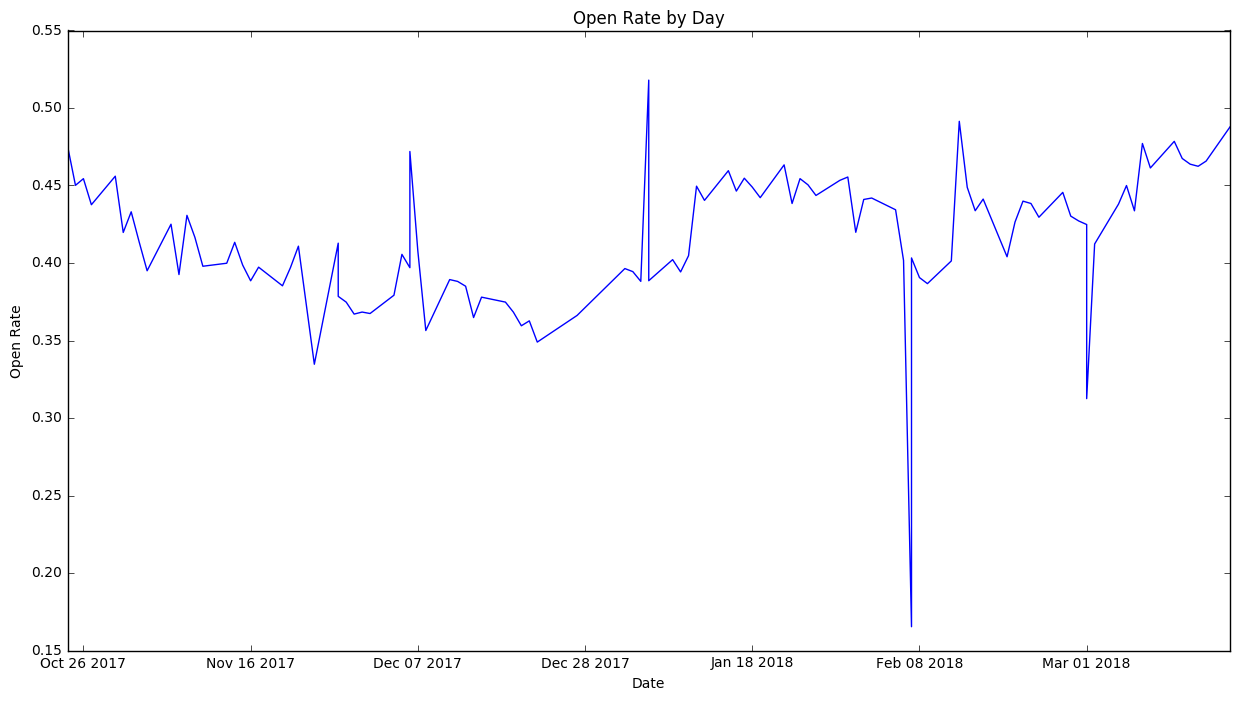

In [111]:
plt.figure(figsize = (15,8))
plt.plot(df['date'],df['open_rate'])
plt.title('Open Rate by Day')
plt.xlabel('Date')
plt.ylabel('Open Rate');

In [112]:
# Pickle Save
df.to_pickle('campaignmonitor_open.pickle')

### Opens by Individual by Email

In [ ]:
df2 = pd.read_sql_query('''
WITH subquery1 as (
SELECT campaignid, subject, name, sentdate 
FROM campaignmonitor_aggregate.campaigns
WHERE DATEPART(dw, sentdate) NOT IN (0,6) 
AND lower(name) !~* 'ambassador|dedicated share message|re-engage'
), 

subquery2 as (
SELECT emailaddress, campaignid, date
FROM campaignmonitor_aggregate.opens
)

SELECT subquery1.campaignid, subquery1.subject, subquery1.name, subquery1.sentdate, 
    subquery2.emailaddress, subquery2.date as opendate
FROM subquery1 
JOIN subquery2 on subquery1.campaignid = subquery2.campaignid
''',cnx)

In [ ]:
df2['campaignid','name','sentdate','emailaddress','opendate'].sort_values(by='sentdate', ascending=False).head()

In [116]:
df2['sentdate_only'] = df2['sentdate'].dt.date
df2['opendate_only'] = df2['opendate'].dt.date
df2['Count'] = 1
df2.drop_duplicates(subset = ['emailaddress','sentdate_only'], inplace=True)
df2['sent_day_of_week'] = df2['sentdate'].dt.weekday

In [117]:
# Pickle Save
df2.to_pickle('eda_df.pickle')
df2 = pd.read_pickle('eda_df.pickle')

In [118]:
df_pivot = pd.pivot_table(df2, values = 'Count', index=['emailaddress'], columns=['sentdate_only'], aggfunc=np.sum)

In [119]:
df_pivot = df_pivot.applymap(lambda x: 1 if x>0 else 0)

In [120]:
df_pivot = df_pivot.fillna(0)

In [122]:
# Pickle Read of Previous Data
df_all = pd.read_pickle('df_refer_unsubscribe_activep5.pickle')

In [123]:
df_all.head()

,id,email,referral_code,referral_count,region,countryname,region_count,created_date,referrer_id,referrer_email,referrer_referral_count,referrer_region,referrer_country,referrer_regioncount,referrer_created_date,sid,emailaddress_x,unsubscribe_date,Time_to_Unsubscribe,Time_to_refer,Time_to_refer_int,Time_to_Unsubscribe_int,newsletters_opened_in_first_10,newsletter_read_bool,newsletter_read_over_5_bool,Referrer_Level,Was_referred_bool,Referred_at_least_one,College_email_bool,Unsubscribed_Bool,referred_someone_Bool,Referrer_Level_Simplified,Code,Paid/Unpaid,Source,paid,unpaid
0,350237.0,ruiwen@gmail.com,8113dc,0.0,New York,United States of America,3.0,2017-11-02,36924.0,landon.medlock@gmail.com,7.0,New York,United States of America,4.0,2016-09-28,0002001,ruiwen@gmail.com,2018-01-03 03:16:00,62 days 03:16:00,400 days,400.0,62.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
1,373343.0,20mearrac@blraiders.org,b80b20,0.0,Texas,United States of America,4.0,2018-01-11,32590.0,wooda@benjaminlogan.org,96.0,New York,United States of America,13.0,2016-09-28,0002001,NaN,NaT,NaT,470 days,470.0,NaN,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
2,195724.0,ahw95@aol.com,83b21c,5.0,Pennsylvania,United States of America,96.0,2017-07-13,124961.0,jm645594@sju.edu,21.0,Texas,United States of America,25.0,2017-02-11,0002001,NaN,NaT,NaT,152 days,152.0,NaN,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,0002001,unpaid,LP for Referred,0,1
3,390888.0,djbasile@go.olemiss.edu,842b29,0.0,Louisiana,United States of America,2.0,2018-02-01,383407.0,connormorenzi@gmail.com,0.0,Mississippi,United States of America,10.0,2018-01-25,0002001,NaN,NaT,NaT,7 days,7.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
4,400702.0,taylor.harper@live.ca,580a7e,1.0,Ontario,Canada,58.0,2018-02-08,189039.0,jacob.neufang@gmail.com,4.0,Ontario,Canada,1026.0,2017-06-12,0002001,NaN,NaT,NaT,241 days,241.0,NaN,5.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0002001,unpaid,LP for Referred,0,1


Filter Users

In [126]:
df_at_least_30 = df_all[(df_all.created_date >'2017-10-15') & (df_all.created_date < '2018-2-1')][['email','created_date']]

In [127]:
df_pivot_unstack = df_pivot.unstack()

In [128]:
df_pivot_unstack = df_pivot_unstack.reset_index()

In [129]:
df_pivot_unstack[df_pivot_unstack.emailaddress == '15kac15@gmail.com'].tail()

,sentdate_only,emailaddress,0
17419502,2018-03-13,15kac15@gmail.com,0
17593695,2018-03-14,15kac15@gmail.com,0
17767888,2018-03-15,15kac15@gmail.com,0
17942081,2018-03-16,15kac15@gmail.com,0
18116274,2018-03-19,15kac15@gmail.com,0


In [131]:
df_pivot_subset = pd.merge(df_pivot_unstack, df_at_least_30, how = 'inner', left_on = 'emailaddress', right_on = 'email')

In [132]:
df_pivot_subset.head()

,sentdate_only,emailaddress,0,email,created_date
0,2017-10-16,00012013@uca.edu.sv,0,00012013@uca.edu.sv,2017-10-29
1,2017-10-17,00012013@uca.edu.sv,0,00012013@uca.edu.sv,2017-10-29
2,2017-10-18,00012013@uca.edu.sv,0,00012013@uca.edu.sv,2017-10-29
3,2017-10-19,00012013@uca.edu.sv,0,00012013@uca.edu.sv,2017-10-29
4,2017-10-20,00012013@uca.edu.sv,0,00012013@uca.edu.sv,2017-10-29


In [133]:
df_pivot_subset.drop(['email'], axis=1, inplace=True)
df_pivot_subset.head()

,sentdate_only,emailaddress,0,created_date
0,2017-10-16,00012013@uca.edu.sv,0,2017-10-29
1,2017-10-17,00012013@uca.edu.sv,0,2017-10-29
2,2017-10-18,00012013@uca.edu.sv,0,2017-10-29
3,2017-10-19,00012013@uca.edu.sv,0,2017-10-29
4,2017-10-20,00012013@uca.edu.sv,0,2017-10-29


In [134]:
df_pivot_subset['sentdate_only'] = pd.to_datetime(df_pivot_subset['sentdate_only'])
df_pivot_subset = df_pivot_subset[df_pivot_subset.sentdate_only >= df_pivot_subset.created_date]
df_pivot_subset.drop('created_date', axis =1, inplace=True)
df_pivot_subset.head()

,sentdate_only,emailaddress,0
10,2017-10-30,00012013@uca.edu.sv,1
11,2017-10-31,00012013@uca.edu.sv,1
12,2017-11-01,00012013@uca.edu.sv,1
13,2017-11-02,00012013@uca.edu.sv,1
14,2017-11-03,00012013@uca.edu.sv,1


In [135]:
df_pivot_subset_pivoted = pd.pivot_table(df_pivot_subset, values = 0, index=['emailaddress'], columns=['sentdate_only'], aggfunc=np.sum)
df_pivot_subset_pivoted.reset_index(inplace=True)
df_pivot_subset_pivoted.set_index('emailaddress').head()

sentdate_only,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00,2017-10-25 00:00:00,2017-10-26 00:00:00,2017-10-27 00:00:00,2017-10-30 00:00:00,2017-10-31 00:00:00,2017-11-01 00:00:00,2017-11-02 00:00:00,2017-11-03 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-13 00:00:00,2017-11-14 00:00:00,2017-11-15 00:00:00,2017-11-16 00:00:00,2017-11-17 00:00:00,2017-11-20 00:00:00,2017-11-21 00:00:00,2017-11-22 00:00:00,2017-11-24 00:00:00,2017-11-27 00:00:00,2017-11-28 00:00:00,2017-11-29 00:00:00,2017-11-30 00:00:00,2017-12-01 00:00:00,2017-12-04 00:00:00,2017-12-05 00:00:00,2017-12-06 00:00:00,2017-12-07 00:00:00,2017-12-08 00:00:00,2017-12-11 00:00:00,2017-12-12 00:00:00,2017-12-13 00:00:00,2017-12-14 00:00:00,2017-12-15 00:00:00,2017-12-18 00:00:00,2017-12-19 00:00:00,2017-12-20 00:00:00,2017-12-21 00:00:00,2017-12-22 00:00:00,2017-12-27 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,2018-01-10 00:00:00,2018-01-11 00:00:00,2018-01-12 00:00:00,2018-01-15 00:00:00,2018-01-16 00:00:00,2018-01-17 00:00:00,2018-01-18 00:00:00,2018-01-19 00:00:00,2018-01-22 00:00:00,2018-01-23 00:00:00,2018-01-24 00:00:00,2018-01-25 00:00:00,2018-01-26 00:00:00,2018-01-29 00:00:00,2018-01-30 00:00:00,2018-01-31 00:00:00,2018-02-01 00:00:00,2018-02-02 00:00:00,2018-02-05 00:00:00,2018-02-06 00:00:00,2018-02-07 00:00:00,2018-02-08 00:00:00,2018-02-09 00:00:00,2018-02-12 00:00:00,2018-02-13 00:00:00,2018-02-14 00:00:00,2018-02-15 00:00:00,2018-02-16 00:00:00,2018-02-19 00:00:00,2018-02-20 00:00:00,2018-02-21 00:00:00,2018-02-22 00:00:00,2018-02-23 00:00:00,2018-02-26 00:00:00,2018-02-27 00:00:00,2018-02-28 00:00:00,2018-03-01 00:00:00,2018-03-02 00:00:00,2018-03-05 00:00:00,2018-03-06 00:00:00,2018-03-07 00:00:00,2018-03-08 00:00:00,2018-03-09 00:00:00,2018-03-12 00:00:00,2018-03-13 00:00:00,2018-03-14 00:00:00,2018-03-15 00:00:00,2018-03-16 00:00:00,2018-03-19 00:00:00
emailaddress,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00012013@uca.edu.sv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
007mnguyen@gmail.com,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009851@mtka.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
011096@live.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
014043@mtka.org

In [137]:
# This function reshapes the data so it is possible to compare users first X emails regardless of the day received3
l = df_pivot_subset_pivoted.shape[1]
df3 = df_pivot_subset_pivoted.copy()
for row, ser in df_pivot_subset_pivoted.iterrows():
    val = ser[ser.notnull()]
    nans = np.full(l - len(val), np.nan)
    newrow = np.concatenate((val, nans))
    df3.iloc[row] = newrow

In [138]:
df3.columns = ['emailaddress'] + ['Email_'+str(i+1) for i in range(len(df3.columns)-1)]

In [139]:
df3.head()

,emailaddress,Email_1,Email_2,Email_3,Email_4,Email_5,Email_6,Email_7,Email_8,Email_9,Email_10,Email_11,Email_12,Email_13,Email_14,Email_15,Email_16,Email_17,Email_18,Email_19,Email_20,Email_21,Email_22,Email_23,Email_24,Email_25,Email_26,Email_27,Email_28,Email_29,Email_30,Email_31,Email_32,Email_33,Email_34,Email_35,Email_36,Email_37,Email_38,Email_39,Email_40,Email_41,Email_42,Email_43,Email_44,Email_45,Email_46,Email_47,Email_48,Email_49,Email_50,Email_51,Email_52,Email_53,Email_54,Email_55,Email_56,Email_57,Email_58,Email_59,Email_60,Email_61,Email_62,Email_63,Email_64,Email_65,Email_66,Email_67,Email_68,Email_69,Email_70,Email_71,Email_72,Email_73,Email_74,Email_75,Email_76,Email_77,Email_78,Email_79,Email_80,Email_81,Email_82,Email_83,Email_84,Email_85,Email_86,Email_87,Email_88,Email_89,Email_90,Email_91,Email_92,Email_93,Email_94,Email_95,Email_96,Email_97,Email_98,Email_99,Email_100,Email_101,Email_102,Email_103,Email_104,Email_105
0,00012013@uca.edu.sv,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,007mnguyen@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2,009851@mtka.org,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,011096@live.com,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,014043@mtka.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
# Pickle Save
df3.to_pickle('df_read_unread_by_day.pickle')
df3 = pd.read_pickle('df_read_unread_by_day.pickle')

In [140]:
# Derive First 10
df_first_10 = df3[df3.columns[:11]]

# Derive First 30
df_first_30 = df3[df3.columns[:31]]

In [141]:
df_first_30.head()

,emailaddress,Email_1,Email_2,Email_3,Email_4,Email_5,Email_6,Email_7,Email_8,Email_9,Email_10,Email_11,Email_12,Email_13,Email_14,Email_15,Email_16,Email_17,Email_18,Email_19,Email_20,Email_21,Email_22,Email_23,Email_24,Email_25,Email_26,Email_27,Email_28,Email_29,Email_30
0,00012013@uca.edu.sv,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,007mnguyen@gmail.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,009851@mtka.org,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,011096@live.com,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4,014043@mtka.org,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Clustering

In [161]:
random.seed(0)

In [162]:
K = KMeans()

In [174]:
df_first_30.head()

,emailaddress,Email_1,Email_2,Email_3,Email_4,Email_5,Email_6,Email_7,Email_8,Email_9,Email_10,Email_11,Email_12,Email_13,Email_14,Email_15,Email_16,Email_17,Email_18,Email_19,Email_20,Email_21,Email_22,Email_23,Email_24,Email_25,Email_26,Email_27,Email_28,Email_29,Email_30,Grouping_30,Emails_opened_30
0,00012013@uca.edu.sv,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,30
1,007mnguyen@gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1
2,009851@mtka.org,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,0,1,2,21
3,011096@live.com,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,1,1,1,1,1,2,22
4,014043@mtka.org,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1


In [176]:
df_first_30.iloc[:,1:] = df_first_30.iloc[:,1:-2].applymap(lambda x: 1 if x>0 else 0)

In [175]:
df_first_10.iloc[:,1:] = df_first_10.iloc[:,1:-2].applymap(lambda x: 1 if x>0 else 0)

In [165]:
inertia_holder = []
for x in range(1,15):
    kmeans = KMeans(n_clusters=x, random_state=0).fit(df_first_30.iloc[:, 1:])
    inertia_holder.append(kmeans.inertia_)

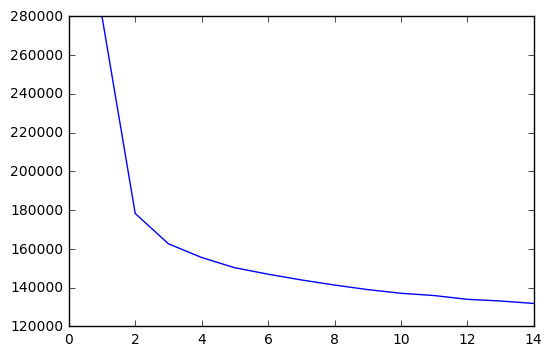

In [166]:
plt.plot([x for x in range(1,15)], inertia_holder)

Clustering Based on Total Emails Read in First 10 and 30 Days

In [227]:
kmeans = KMeans(n_clusters=3, n_init = 20, max_iter = 300, random_state=0).fit(df_first_10.iloc[:, -1:])
df_first_10['Grouping_10'] = kmeans.labels_

In [228]:
kmeans = KMeans(n_clusters=5, n_init = 20, max_iter = 300, random_state=0).fit(df_first_30.iloc[:, -1:])
df_first_30['Grouping_30'] = kmeans.labels_

In [229]:
df_first_30.iloc[:, :].head()

,emailaddress,Email_1,Email_2,Email_3,Email_4,Email_5,Email_6,Email_7,Email_8,Email_9,Email_10,Email_11,Email_12,Email_13,Email_14,Email_15,Email_16,Email_17,Email_18,Email_19,Email_20,Email_21,Email_22,Email_23,Email_24,Email_25,Email_26,Email_27,Email_28,Email_29,Email_30,Grouping_30,Emails_opened_30
0,00012013@uca.edu.sv,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,30
1,007mnguyen@gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,009851@mtka.org,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,0,1,1,21
3,011096@live.com,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,1,1,1,1,1,1,22
4,014043@mtka.org,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [230]:
df_first_30['Emails_opened_30'] = df_first_30.iloc[: ,1:-2].sum(axis=1)

In [231]:
df_first_10['Emails_opened_10'] = df_first_10.iloc[: ,1:-2].sum(axis=1)

In [232]:
df_first_10.groupby('Grouping_10')['Emails_opened_10'].describe()

,count,mean,std,min,25%,50%,75%,max
Grouping_10,,,,,,,,
0,15316.0,8.568229,0.975431,7.0,8.0,9.0,9.0,10.0
1,10611.0,0.936764,0.813445,0.0,0.0,1.0,2.0,2.0
2,10803.0,4.478478,1.121723,3.0,3.0,4.0,5.0,6.0


In [233]:
df_first_30.groupby('Grouping_30')['Emails_opened_30'].describe()

,count,mean,std,min,25%,50%,75%,max
Grouping_30,,,,,,,,
0,8649.0,2.102093,1.293478,0.0,1.0,2.0,3.0,4.0
1,6101.0,21.058023,2.002354,18.0,19.0,21.0,23.0,24.0
2,6229.0,13.924065,1.990790,11.0,12.0,14.0,16.0,17.0
3,8563.0,27.808128,1.549380,25.0,27.0,28.0,29.0,30.0
4,7188.0,7.305509,1.724084,5.0,6.0,7.0,9.0,10.0


In [234]:
# Pickle Save
df_first_30.to_pickle('df_first_30.pickle')

In [235]:
df_first_10_grouped = df_first_10[['emailaddress','Grouping_10','Emails_opened_10']]

In [236]:
df_first_30_grouped = df_first_30[['emailaddress','Grouping_30','Emails_opened_30']]

First Merge

In [237]:
df_30_merge = pd.merge(df_first_30_grouped, df_all, how = 'inner', left_on = 'emailaddress', right_on = 'email')

Second Merge

In [238]:
df_10_30_merge = pd.merge(df_first_10_grouped, df_30_merge, how = 'inner', left_on = 'emailaddress', right_on = 'email')

In [239]:
df_10_30_merge.drop(['emailaddress_y','emailaddress_x'], axis =1, inplace=True)

In [240]:
# Pickle Save
df_10_30_merge.to_pickle('df_10_30_merge.pickle')
df_10_30_merge = pd.read_pickle('df_10_30_merge.pickle')

In [244]:
percentiles = [x/10 for x in range(1,10)]

In [245]:
df_10_30_merge.groupby(['Referrer_Level_Simplified'])['Time_to_Unsubscribe_int'].describe(percentiles = percentiles).sort_values(by='mean', ascending=False)

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
Referrer_Level_Simplified,,,,,,,,,,,,,,
1.0,53.0,57.528302,42.573739,4.0,8.2,14.6,29.0,36.6,48.0,58.2,76.8,108.2,121.8,151.0
0.0,2873.0,41.743822,33.879453,0.0,5.0,9.0,17.0,26.0,35.0,45.0,55.0,70.0,92.0,151.0
2.0,3.0,28.333333,16.165808,11.0,15.0,19.0,23.0,27.0,31.0,33.4,35.8,38.2,40.6,43.0


In [246]:
df_unsubscribes_10_30 = df_10_30_merge[['email','unsubscribe_date']]

#### Evaluate Last Read Emails

In [247]:
df_pivot_last_emails = pd.merge(df_pivot_subset, df_unsubscribes_10_30, how='outer'\
                                , left_on = 'emailaddress', right_on = 'email')

In [250]:
df_pivot_last_emails_dropped = df_pivot_last_emails.drop(df_pivot_last_emails[df_pivot_last_emails.unsubscribe_date < (df_pivot_last_emails.sentdate_only + datetime.timedelta(days=1))].index)

In [251]:
df_pivot_last_emails_dropped.drop(['email','unsubscribe_date'], axis =1, inplace=True)

In [252]:
df_pivot_last_emails_dropped_pivot = pd.pivot_table(df_pivot_last_emails_dropped, values = 0, index=['emailaddress'], columns=['sentdate_only'], aggfunc=np.sum)

In [253]:
df_pivot_last_emails_dropped_pivot.head()

sentdate_only,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00,2017-10-25 00:00:00,2017-10-26 00:00:00,2017-10-27 00:00:00,2017-10-30 00:00:00,2017-10-31 00:00:00,2017-11-01 00:00:00,2017-11-02 00:00:00,2017-11-03 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-13 00:00:00,2017-11-14 00:00:00,2017-11-15 00:00:00,2017-11-16 00:00:00,2017-11-17 00:00:00,2017-11-20 00:00:00,2017-11-21 00:00:00,2017-11-22 00:00:00,2017-11-24 00:00:00,2017-11-27 00:00:00,2017-11-28 00:00:00,2017-11-29 00:00:00,2017-11-30 00:00:00,2017-12-01 00:00:00,2017-12-04 00:00:00,2017-12-05 00:00:00,2017-12-06 00:00:00,2017-12-07 00:00:00,2017-12-08 00:00:00,2017-12-11 00:00:00,2017-12-12 00:00:00,2017-12-13 00:00:00,2017-12-14 00:00:00,2017-12-15 00:00:00,2017-12-18 00:00:00,2017-12-19 00:00:00,2017-12-20 00:00:00,2017-12-21 00:00:00,2017-12-22 00:00:00,2017-12-27 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,2018-01-10 00:00:00,2018-01-11 00:00:00,2018-01-12 00:00:00,2018-01-15 00:00:00,2018-01-16 00:00:00,2018-01-17 00:00:00,2018-01-18 00:00:00,2018-01-19 00:00:00,2018-01-22 00:00:00,2018-01-23 00:00:00,2018-01-24 00:00:00,2018-01-25 00:00:00,2018-01-26 00:00:00,2018-01-29 00:00:00,2018-01-30 00:00:00,2018-01-31 00:00:00,2018-02-01 00:00:00,2018-02-02 00:00:00,2018-02-05 00:00:00,2018-02-06 00:00:00,2018-02-07 00:00:00,2018-02-08 00:00:00,2018-02-09 00:00:00,2018-02-12 00:00:00,2018-02-13 00:00:00,2018-02-14 00:00:00,2018-02-15 00:00:00,2018-02-16 00:00:00,2018-02-19 00:00:00,2018-02-20 00:00:00,2018-02-21 00:00:00,2018-02-22 00:00:00,2018-02-23 00:00:00,2018-02-26 00:00:00,2018-02-27 00:00:00,2018-02-28 00:00:00,2018-03-01 00:00:00,2018-03-02 00:00:00,2018-03-05 00:00:00,2018-03-06 00:00:00,2018-03-07 00:00:00,2018-03-08 00:00:00,2018-03-09 00:00:00,2018-03-12 00:00:00,2018-03-13 00:00:00,2018-03-14 00:00:00,2018-03-15 00:00:00,2018-03-16 00:00:00,2018-03-19 00:00:00
emailaddress,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00012013@uca.edu.sv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
007mnguyen@gmail.com,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009851@mtka.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
011096@live.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
014043@mtka.org

In [254]:
df_pivot_last_emails_dropped_pivot.to_pickle('df_pivot_last_emails.pickle')

In [255]:
df_pivot_last_emails_dropped_pivot.reset_index(inplace=True)

In [256]:
df_pivot_last_emails_dropped_pivot.head()

sentdate_only,emailaddress,2017-10-16 00:00:00,2017-10-17 00:00:00,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00,2017-10-25 00:00:00,2017-10-26 00:00:00,2017-10-27 00:00:00,2017-10-30 00:00:00,2017-10-31 00:00:00,2017-11-01 00:00:00,2017-11-02 00:00:00,2017-11-03 00:00:00,2017-11-06 00:00:00,2017-11-07 00:00:00,2017-11-08 00:00:00,2017-11-09 00:00:00,2017-11-10 00:00:00,2017-11-13 00:00:00,2017-11-14 00:00:00,2017-11-15 00:00:00,2017-11-16 00:00:00,2017-11-17 00:00:00,2017-11-20 00:00:00,2017-11-21 00:00:00,2017-11-22 00:00:00,2017-11-24 00:00:00,2017-11-27 00:00:00,2017-11-28 00:00:00,2017-11-29 00:00:00,2017-11-30 00:00:00,2017-12-01 00:00:00,2017-12-04 00:00:00,2017-12-05 00:00:00,2017-12-06 00:00:00,2017-12-07 00:00:00,2017-12-08 00:00:00,2017-12-11 00:00:00,2017-12-12 00:00:00,2017-12-13 00:00:00,2017-12-14 00:00:00,2017-12-15 00:00:00,2017-12-18 00:00:00,2017-12-19 00:00:00,2017-12-20 00:00:00,2017-12-21 00:00:00,2017-12-22 00:00:00,2017-12-27 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,2018-01-10 00:00:00,2018-01-11 00:00:00,2018-01-12 00:00:00,2018-01-15 00:00:00,2018-01-16 00:00:00,2018-01-17 00:00:00,2018-01-18 00:00:00,2018-01-19 00:00:00,2018-01-22 00:00:00,2018-01-23 00:00:00,2018-01-24 00:00:00,2018-01-25 00:00:00,2018-01-26 00:00:00,2018-01-29 00:00:00,2018-01-30 00:00:00,2018-01-31 00:00:00,2018-02-01 00:00:00,2018-02-02 00:00:00,2018-02-05 00:00:00,2018-02-06 00:00:00,2018-02-07 00:00:00,2018-02-08 00:00:00,2018-02-09 00:00:00,2018-02-12 00:00:00,2018-02-13 00:00:00,2018-02-14 00:00:00,2018-02-15 00:00:00,2018-02-16 00:00:00,2018-02-19 00:00:00,2018-02-20 00:00:00,2018-02-21 00:00:00,2018-02-22 00:00:00,2018-02-23 00:00:00,2018-02-26 00:00:00,2018-02-27 00:00:00,2018-02-28 00:00:00,2018-03-01 00:00:00,2018-03-02 00:00:00,2018-03-05 00:00:00,2018-03-06 00:00:00,2018-03-07 00:00:00,2018-03-08 00:00:00,2018-03-09 00:00:00,2018-03-12 00:00:00,2018-03-13 00:00:00,2018-03-14 00:00:00,2018-03-15 00:00:00,2018-03-16 00:00:00,2018-03-19 00:00:00
0,00012013@uca.edu.sv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,007mnguyen@gmail.com,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,009851@mtka.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,011096@live.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
4,014043@mtka.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

This function is the same as the one above however this looks at the last tweets received

In [257]:
l = df_pivot_last_emails_dropped_pivot.shape[1]
df4 = df_pivot_last_emails_dropped_pivot.copy()
for row, ser in df_pivot_last_emails_dropped_pivot.iterrows():
    val = ser[ser.notnull()]
    nans = np.full(l - len(val), np.nan)
    newrow = np.concatenate((val, nans))
    df4.iloc[row] = newrow

In [258]:
df4.columns = ['emailaddress'] + ['Last_Email_'+str(i+1) for i in range(len(df4.columns)-1)]

In [259]:
df_last_10 = df4[df4.columns[:11]]
df_last_30 = df4[df4.columns[:31]]

In [261]:
df_last_10.iloc[:,1:] = df_last_10.iloc[:,1:].applymap(lambda x: 1 if x>0 else 0)
df_last_30.iloc[:,1:] = df_last_30.iloc[:,1:].applymap(lambda x: 1 if x>0 else 0)

### Groupings of Last 10 and 30 Emails

In [262]:
kmeans = KMeans(n_clusters=3, n_init = 20, max_iter = 300, random_state=0).fit(df_last_10.iloc[:, 1:-2])
df_last_10['Grouping_10_last'] = kmeans.labels_

In [263]:
kmeans = KMeans(n_clusters=5, n_init = 20, max_iter = 300, random_state=0).fit(df_last_30.iloc[:, 1:-2])
df_last_30['Grouping_30_last'] = kmeans.labels_

In [269]:
df_last_30['Emails_opened_30_last'] = df_last_30.iloc[: ,1:-2].sum(axis=1)

In [270]:
df_last_10['Emails_opened_10_last'] = df_last_10.iloc[: ,1:-2].sum(axis=1)

In [271]:
df_last_30.head()

,emailaddress,Last_Email_1,Last_Email_2,Last_Email_3,Last_Email_4,Last_Email_5,Last_Email_6,Last_Email_7,Last_Email_8,Last_Email_9,Last_Email_10,Last_Email_11,Last_Email_12,Last_Email_13,Last_Email_14,Last_Email_15,Last_Email_16,Last_Email_17,Last_Email_18,Last_Email_19,Last_Email_20,Last_Email_21,Last_Email_22,Last_Email_23,Last_Email_24,Last_Email_25,Last_Email_26,Last_Email_27,Last_Email_28,Last_Email_29,Last_Email_30,Grouping_30_last,Emails_opened_30_last,Grouping_30_last_total
0,00012013@uca.edu.sv,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,30,0
1,007mnguyen@gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,5,1
2,009851@mtka.org,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,0,1,0,21,0
3,011096@live.com,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0,22,0
4,014043@mtka.org,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,1


### Groupings of Last 10 and 30 Emails - Total

In [272]:
kmeans = KMeans(n_clusters=3, n_init = 20, max_iter = 300, random_state=0).fit(df_last_10.iloc[:, -2:-1])
df_last_10['Grouping_10_last_total'] = kmeans.labels_

In [279]:
kmeans = KMeans(n_clusters=3, n_init = 20, max_iter = 300, random_state=0).fit(df_last_30.iloc[:, -2:-1])
df_last_30['Grouping_30_last_total'] = kmeans.labels_

In [281]:
df_last_30.head()

,emailaddress,Last_Email_1,Last_Email_2,Last_Email_3,Last_Email_4,Last_Email_5,Last_Email_6,Last_Email_7,Last_Email_8,Last_Email_9,Last_Email_10,Last_Email_11,Last_Email_12,Last_Email_13,Last_Email_14,Last_Email_15,Last_Email_16,Last_Email_17,Last_Email_18,Last_Email_19,Last_Email_20,Last_Email_21,Last_Email_22,Last_Email_23,Last_Email_24,Last_Email_25,Last_Email_26,Last_Email_27,Last_Email_28,Last_Email_29,Last_Email_30,Grouping_30_last,Emails_opened_30_last,Grouping_30_last_total
0,00012013@uca.edu.sv,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,30,0
1,007mnguyen@gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4,5,1
2,009851@mtka.org,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,1,1,0,0,1,0,21,2
3,011096@live.com,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,0,1,1,1,1,1,0,22,0
4,014043@mtka.org,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,1


In [260]:
df_last_30.to_pickle('df_last_30.pickle')
df_last_10.to_pickle('df_last_10.pickle')
df_last_30 = pd.read_pickle('df_last_30.pickle')
df_last_10 = pd.read_pickle('df_last_10.pickle')

In [282]:
df_last_10_grouped = df_last_10[['emailaddress','Grouping_10_last','Emails_opened_10_last','Grouping_10_last_total']]

In [283]:
df_last_30_grouped = df_last_30[['emailaddress','Grouping_30_last','Emails_opened_30_last','Grouping_30_last_total']]

In [284]:
df_last30_merge = pd.merge(df_last_30_grouped, df_10_30_merge, how = 'inner', left_on = 'emailaddress', right_on = 'email')

In [285]:
df_last10_30_merge = pd.merge(df_last_10_grouped, df_last30_merge, how = 'inner', left_on = 'emailaddress', right_on = 'email')

In [286]:
df_last10_30_merge.drop(['emailaddress_y','emailaddress_x'], axis =1, inplace=True)

In [287]:
# Pickle Save
df_last10_30_merge.to_pickle('df_last_1030_merge_combined.pickle')
df_last10_30_merge = pd.read_pickle('df_last_1030_merge_combined.pickle')

## Unsubscribe Prediction

In [288]:
count_unsubscribed = df_last10_30_merge.Unsubscribed_Bool.value_counts()[0]

In [289]:
# Separate majority and minority classes
df_majority = df_last10_30_merge[df_last10_30_merge.Unsubscribed_Bool==0]
df_minority = df_last10_30_merge[df_last10_30_merge.Unsubscribed_Bool==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=int(count_unsubscribed),    # to match majority class
                                 random_state=444)

In [290]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [291]:
variables = ['newsletter_read_bool','Referred_at_least_one',\
             'College_email_bool','Grouping_10','Grouping_30','Grouping_10_last',\
             'Grouping_10_last_total','Grouping_30_last','Grouping_30_last_total']
X = df_upsampled[variables]
y = df_upsampled['Unsubscribed_Bool']

In [292]:
X_train, _, y_train, _ = train_test_split(X,y, test_size = .3 , random_state =444)

In [293]:
X = df_last10_30_merge[variables]
y = df_last10_30_merge['Unsubscribed_Bool']

In [294]:
_,X_test,_, y_test = train_test_split(X,y, test_size = .3 , random_state =444)

In [295]:
# Training classifiers
clf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
            oob_score=False, random_state=444, verbose=0, warm_start=False)
clf2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance')
clf3 = BernoulliNB()
clf4 = AdaBoostClassifier(n_estimators=100, random_state=444)
eclf = VotingClassifier(estimators=[('rf', clf1), ('knn', clf2), ('bnb', clf3), ('ada', clf4)],\
                        voting='soft', weights = [3,1,1,1])

clf1 = clf1.fit(X_train,y_train)
clf2 = clf2.fit(X_train,y_train)
clf3 = clf3.fit(X_train,y_train)
clf4 = clf4.fit(X_train,y_train)
eclf = eclf.fit(X_train,y_train)

In [296]:
eclf_pred = eclf.predict_proba(X_test)

In [297]:
eclf.predict(X_test[:10])

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0.])

In [298]:
eclf_pred[:10]

array([[0.48, 0.52],
       [0.41, 0.59],
       [0.43, 0.57],
       [0.72, 0.28],
       [0.6 , 0.4 ],
       [0.51, 0.49],
       [0.72, 0.28],
       [0.63, 0.37],
       [0.82, 0.18],
       [0.52, 0.48]])

In [299]:
y_pred_vc = []
for x in eclf_pred:
    if x[0]>.55:
        y_pred_vc.append(0)
    else:
        y_pred_vc.append(1)

In [300]:
y_pred_vc_groupings = []
for x in eclf_pred:
    if x[0]>=.95:
        y_pred_vc_groupings.append(0)
    elif x[0]>=.90 and x[0]<.95:
        y_pred_vc_groupings.append(1)
    elif x[0]>=.85 and x[0]<.9:
        y_pred_vc_groupings.append(2)
    elif x[0]>=.8 and x[0]<.85:
        y_pred_vc_groupings.append(3)
    elif x[0]>=.75 and x[0]<.8:
        y_pred_vc_groupings.append(4)
    elif x[0]>=.7 and x[0]<.75:
        y_pred_vc_groupings.append(5)
    elif x[0]>=.65 and x[0]<.7:
        y_pred_vc_groupings.append(6)
    elif x[0]>=.6 and x[0]<.65:
        y_pred_vc_groupings.append(7)
    elif x[0]>=.55 and x[0]<.6:
        y_pred_vc_groupings.append(8)
    elif x[0]>=.5 and x[0]<.55:
        y_pred_vc_groupings.append(9)
    elif x[0]>=.45 and x[0]<.5:
        y_pred_vc_groupings.append(10)
    elif x[0]>=.4 and x[0]<.45:
        y_pred_vc_groupings.append(11)
    elif x[0]>=.35 and x[0]< .4:
        y_pred_vc_groupings.append(12)
    elif x[0]>=.3 and x[0]<.35:
        y_pred_vc_groupings.append(13)
    elif x[0]>=.25 and x[0]<.3:
        y_pred_vc_groupings.append(14)
    elif x[0]>=.2 and x[0]<.35:
        y_pred_vc_groupings.append(15)
    elif x[0]>=.15 and x[0]<.2:
        y_pred_vc_groupings.append(16)
    elif x[0]>=.1 and x[0]<.15:
        y_pred_vc_groupings.append(17)
    elif x[0]>=.5 and x[0]<.1:
        y_pred_vc_groupings.append(18)
    else:
        y_pred_vc_groupings.append(19)
    

In [301]:
y_pred_vc_count = Counter(y_pred_vc_groupings)

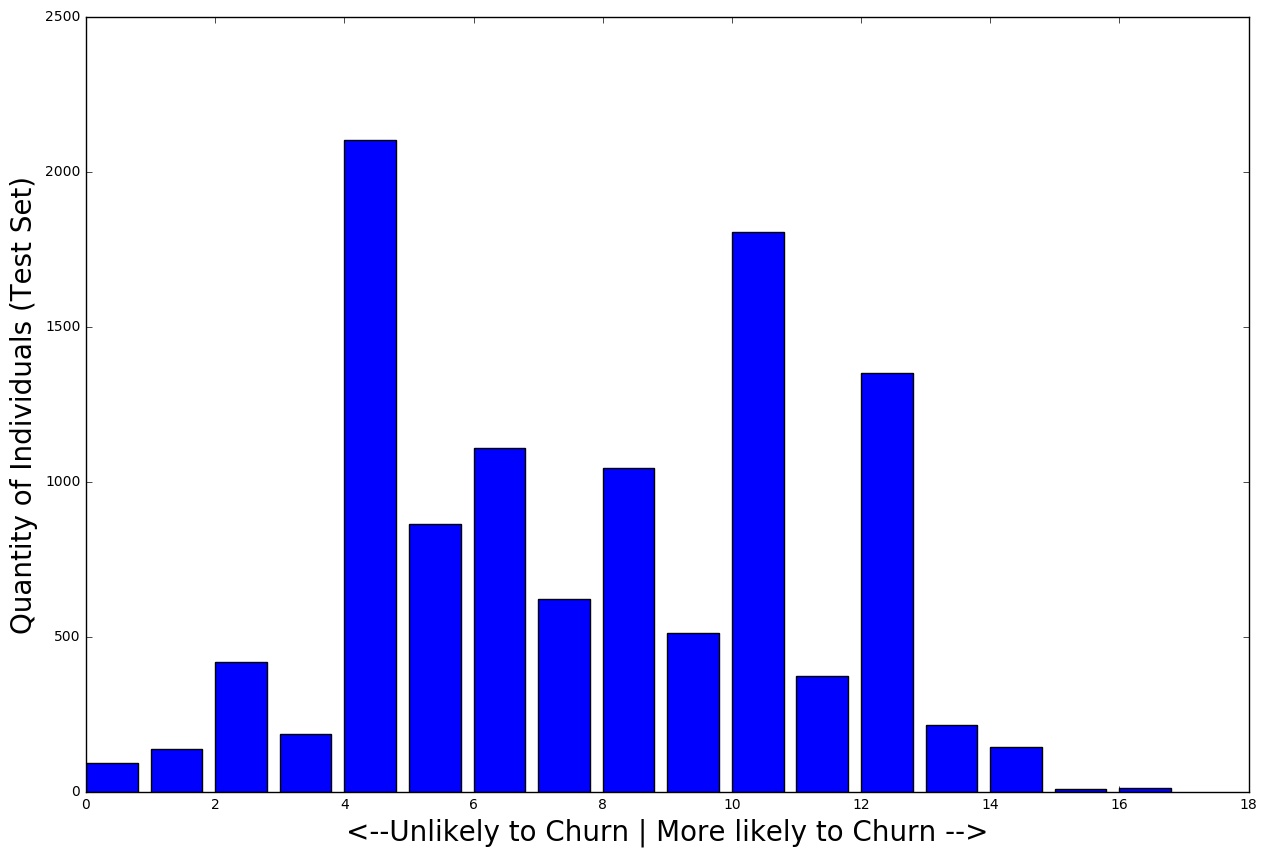

In [302]:
plt.figure(figsize =(15,10))
plt.bar([x for x in range(len(y_pred_vc_count))],list(y_pred_vc_count.values()))
plt.xlabel('<--Unlikely to Churn | More likely to Churn -->', fontsize=20)
plt.ylabel('Quantity of Individuals (Test Set)', fontsize=20);

In [303]:
class_names = ['Subscribed','Unsubscribed']

Confusion matrix, without normalization
[[5353 4769]
 [ 187  704]]
Normalized confusion matrix
[[0.53 0.47]
 [0.21 0.79]]


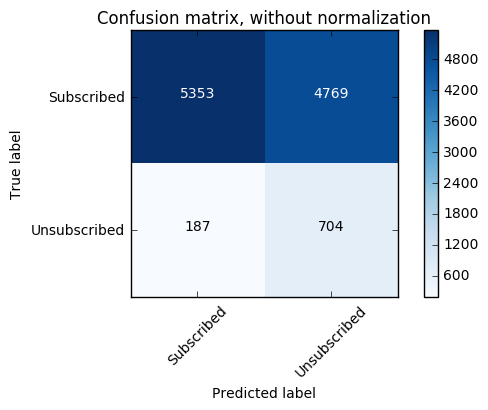

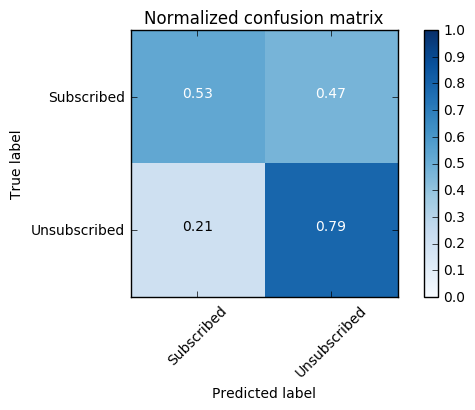

In [306]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if normalize:
        plt.clim(0,1)

       
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_vc)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model Optimization

In [307]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [308]:
variables = ['newsletter_read_bool','Referred_at_least_one',\
             'College_email_bool','Grouping_10','Grouping_30','Grouping_10_last',\
             'Grouping_10_last_total','Grouping_30_last','Grouping_30_last_total']
X = df_upsampled[variables]
y = df_upsampled['Unsubscribed_Bool']

In [309]:
X_train, _, y_train, _ = train_test_split(X,y, test_size = .3 , random_state =444)

In [310]:
X = df_last10_30_merge[variables]
y = df_last10_30_merge['Unsubscribed_Bool']

In [311]:
_,X_test,_, y_test = train_test_split(X,y, test_size = .3 , random_state =444)

#### Random Forest

In [ ]:
parameters_rf = {
    'n_estimators' : [10]+ [i*20 for i in range(1,11)],
    'max_features' : ['auto',None],
    'min_samples_leaf' : [1,2,3,4,5],
    'max_depth' : [4,5,10,None]
}
RF = RandomForestClassifier(random_state =444)
RF_GSCV = GridSearchCV(RF, parameters_rf, n_jobs = -1)
RF_GSCV.fit(X_train,y_train)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(RF_GSCV.get_params())

In [ ]:
best_grid_rf = RF_GSCV.best_estimator_
best_grid_rf

#### KNearestNeighbors

In [ ]:
parameters_knn = {
    'n_neighbors' : [2]+ [i*2 for i in range(2,5)],
    'weights' : ['uniform','distance']
}
KNN = KNeighborsClassifier()
KNN_GSCV = GridSearchCV(KNN, parameters_knn, n_jobs = -1)
KNN_GSCV.fit(X_train,y_train)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(KNN_GSCV.get_params())

In [ ]:
best_grid_knn = KNN_GSCV.best_estimator_
best_grid_knn

#### Bernoulli Naive Bayes

In [ ]:
parameters_bnb = {
    'alpha' : [i/10 for i in range(0,10)],
    
}
BNB = BernoulliNB()
BNB_GSCV = GridSearchCV(BNB, parameters_bnb, n_jobs = -1)
BNB_GSCV.fit(X_train,y_train)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(BNB_GSCV.get_params())

In [ ]:
best_grid_bnb = BNB_GSCV.best_estimator_
best_grid_bnb

#### AdaBoost 

In [ ]:
parameters_ada = {
    'n_estimators' : [i*10 for i in range(1,11)]
    
}
ADA = AdaBoostClassifier()
ADA_GSCV = GridSearchCV(ADA, parameters_ada, n_jobs = -1)
ADA_GSCV.fit(X_train,y_train)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(ADA_GSCV.get_params())

In [ ]:
best_grid_ada = ADA_GSCV.best_estimator_
best_grid_ada

## Network Analysis

In [312]:
df_all = pd.read_pickle('df_refer_unsubscribe_activep5.pickle')

In [313]:
df_last10_30_merge.head()

,Grouping_10_last,Emails_opened_10_last,Grouping_10_last_total,Grouping_30_last,Emails_opened_30_last,Grouping_30_last_total,Grouping_10,Emails_opened_10,Grouping_30,Emails_opened_30,id,email,referral_code,referral_count,region,countryname,region_count,created_date,referrer_id,referrer_email,referrer_referral_count,referrer_region,referrer_country,referrer_regioncount,referrer_created_date,sid,unsubscribe_date,Time_to_Unsubscribe,Time_to_refer,Time_to_refer_int,Time_to_Unsubscribe_int,newsletters_opened_in_first_10,newsletter_read_bool,newsletter_read_over_5_bool,Referrer_Level,Was_referred_bool,Referred_at_least_one,College_email_bool,Unsubscribed_Bool,referred_someone_Bool,Referrer_Level_Simplified,Code,Paid/Unpaid,Source,paid,unpaid
0,1,11,0,0,30,0,0,10,3,30,349354.0,00012013@uca.edu.sv,6f66c9,0.0,California,United States of America,28.0,2017-10-29,NaN,None,NaN,None,None,NaN,NaT,0013001,NaT,NaT,NaT,NaN,NaN,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0013001,unpaid,Quora,0,1
1,0,0,1,4,5,1,1,0,0,1,345296.0,007mnguyen@gmail.com,87f931,0.0,New York,United States of America,7.0,2017-10-19,26604.0,maxwell.a.hopkins@gmail.com,811.0,New York,United States of America,31.0,2016-09-28,0002001,NaT,NaT,386 days,386.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
2,1,8,0,0,21,2,0,7,1,21,359512.0,009851@mtka.org,c6232f,0.0,Minnesota,United States of America,76.0,2017-12-01,11537.0,stephanie.lolich@minnetonka.k12.mn.us,43.0,Minnesota,United States of America,6.0,2016-09-28,0002001,NaT,NaT,429 days,429.0,NaN,5.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
3,1,9,0,0,22,0,0,8,1,22,387027.0,011096@live.com,d511d4,0.0,"London, City of",United Kingdom,43.0,2018-01-30,177126.0,msoteriou@me.com,0.0,California,Cyprus,5.0,2017-04-13,0002001,NaT,NaT,292 days,292.0,NaN,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1
4,0,0,1,4,4,1,1,0,0,1,359894.0,014043@mtka.org,fd8cd0,0.0,Illinois,United States of America,2.0,2017-12-02,11537.0,stephanie.lolich@minnetonka.k12.mn.us,42.0,Minnesota,United States of America,6.0,2016-09-28,0002001,2018-01-09 18:44:00,38 days 18:44:00,430 days,430.0,38.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0002001,unpaid,LP for Referred,0,1


In [314]:
df_network_attributes = pd.merge(df_all, df_last10_30_merge, how = 'outer', left_on = 'email', right_on='email')

In [315]:
vars_for_network = ['referrer_email','referrer_region','referrer_created_date','email',\
                    'referral_code','referral_count','region','countryname','created_date','Grouping_10',\
                    'Grouping_30','Grouping_10_last',\
                     'Grouping_10_last_total','Grouping_30_last','Grouping_30_last_total']
df_network = df_last10_30_merge[vars_for_network]

In [320]:
df_rep =pd.read_sql_query('''SELECT DISTINCT(email), first_name, last_name FROM pg.users 
where rep = True and CAST(created_at as DATE) >'2017-1-1' 
and referral_count >=5 and first_name != 'None'

LIMIT 30''', cnx)

In [321]:
df_rep = df_rep.drop_duplicates(subset = ['email'], keep ='last').reset_index(drop=True)

In [322]:
df_rep

,email,first_name,last_name
0,tomsanta7@yahoo.com,Thomas,Santarcangelo
1,ludanie1@msu.edu,Daniel,Lu
2,eherri@sas.upenn.edu,Eleanor,Herring
3,joeyucci19@gmail.com,Joseph,Ucci
4,doniyellin@gmail.com,Doni,Yellin
5,gsadler@umich.edu,Gabby,Sadler
6,yang.liuke@gmail.com,Liuke,Yang
7,caitlin.edwards@ey.com,Caitlin,Edwards
8,ogdenza@bc.edu,Zachary,Ogden
9,ameyers123@gmail.com,Andy,Meyers


In [323]:
df_rep['full_name'] = df_rep['first_name'] + '_' + df_rep['last_name']

In [325]:
emails = list(df_rep['email'])

In [327]:
names = list(df_rep['full_name'])

In [333]:
zipped_names = list(zip(emails, names))

In [331]:
# def tree_json(zipped_names):
graph = nx.from_pandas_edgelist(df_network,'referrer_email','email',
                                    edge_attr = ['region','countryname','created_date','Grouping_30',\
                                                 'Grouping_30_last_total'],
                                    create_using=nx.DiGraph())
def tree_json(zipped_names):
    for i, k in zipped_names:
        tree = nx.bfs_tree(graph,i)
        data = json_graph.tree_data(tree,root=i)
        with open('TreeJsonsp2/' + str(k+'.json'), 'w') as outfile:
            json.dump(data, outfile)

In [334]:
tree_json(zipped_names)